In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

# SVM

In [3]:
from classifiers.datasets.dataloader import ToyBlochSphereLoader
from classifiers.datasets.datascaler import DataMultiScaler, DataScaler
from classifiers.kernel import Kernel
from classifiers.convex.svm import BinarySVM
from classifiers.visualization import Plot_SVM, Plot_Data


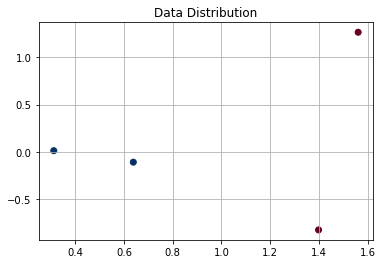

In [4]:
dl = ToyBlochSphereLoader(gap=np.pi/5)
ds = DataScaler('standard')
np.random.seed(30)
X, y = dl(4, 0.1)
kernel = Kernel('SingleQubit')
Plot_Data(X, y).plot()


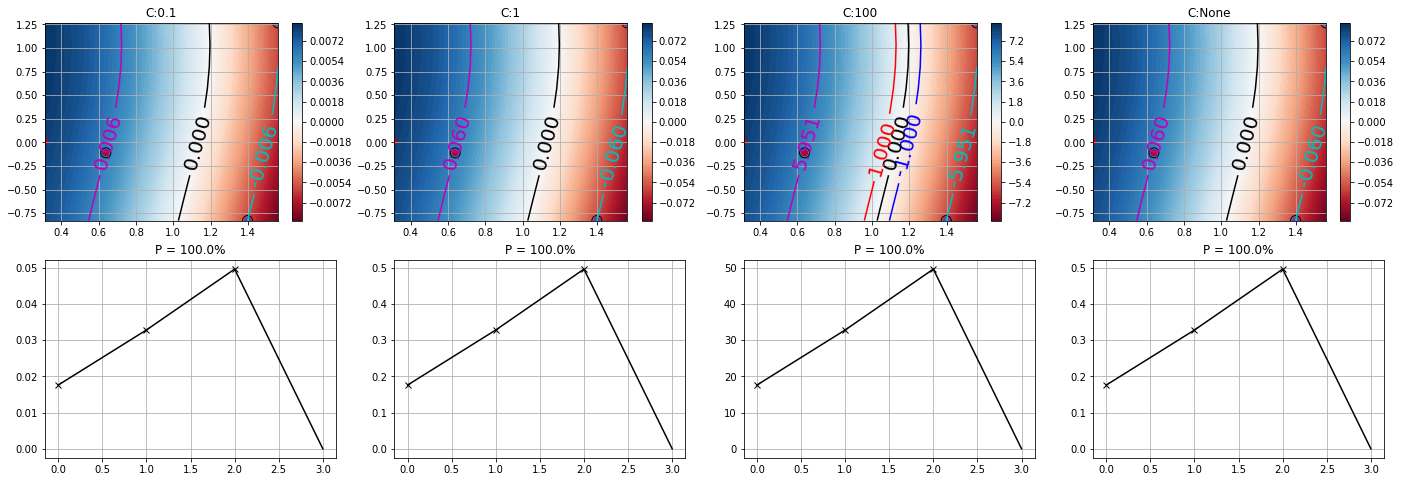

In [5]:
svms = [BinarySVM(kernel, C=C, k=0.1, mutation='REDUCED_QASVM') for C in [0.1, 1, 100, None]]
[svm.fit(X, y) for svm in svms]
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
for n in range(4):
    ax0 = axes[0][n]
    ax1 = axes[1][n]
    plot = Plot_SVM(svms[n])
    plot.plot_boundary(ax=ax0, fig=fig)
    plot.plot('alpha', ax=ax1)
    ax0.set_title(f'C:{svms[n].C}')
    if svms[n].status == 'optimal':
        ax1.set_title(f'P = {100*svms[n].accuracy(X, y)}%')
    else:
        ax1.set_title('Not Optimal')
    

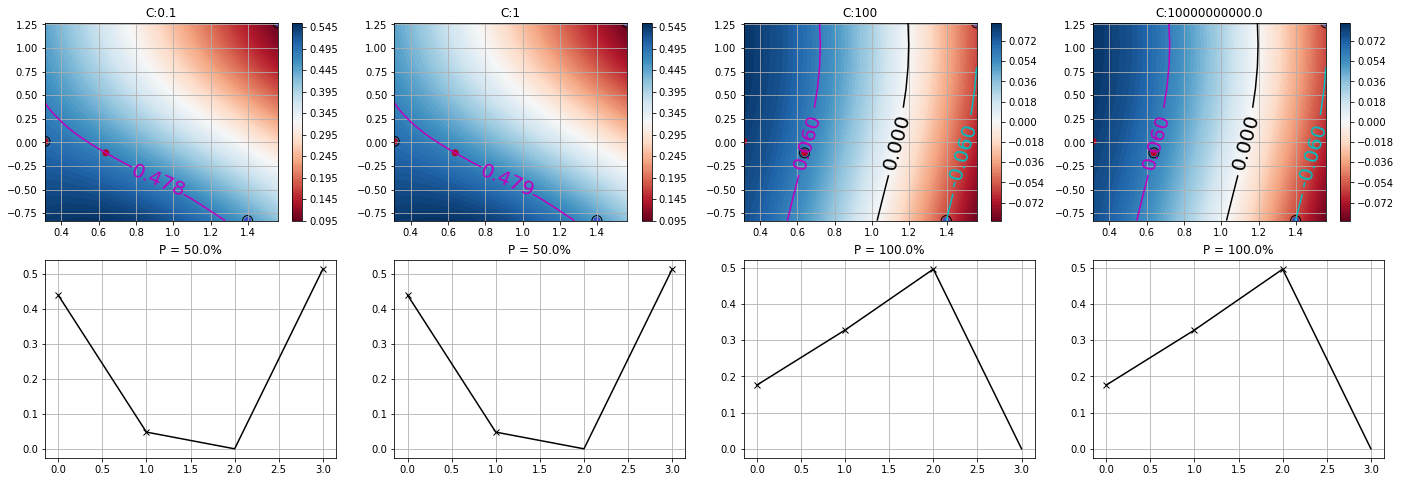

In [6]:
svms = [BinarySVM(kernel, C=C, k=0.1, mutation='REDUCED_primal_QASVM') for C in [0.1, 1, 100, 1e10]]
[svm.fit(X, y) for svm in svms]
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
for n in range(4):
    ax0 = axes[0][n]
    ax1 = axes[1][n]
    plot = Plot_SVM(svms[n])
    plot.plot_boundary(ax=ax0, fig=fig)
    plot.plot('alpha', ax=ax1)
    ax0.set_title(f'C:{svms[n].C}')
    if svms[n].status == 'optimal':
        ax1.set_title(f'P = {100*svms[n].accuracy(X, y)}%')
    else:
        ax1.set_title('Not Optimal')

In [7]:
svm = BinarySVM(kernel, C=None, k=0.1, mutation='REDUCED_QASVM')
svm.fit(X, y)

# QASVM with Noise Model

In [8]:
from classifiers.datasets.dataloader import ToyBlochSphereLoader
from classifiers.datasets.datascaler import DataMultiScaler, DataScaler
from classifiers.quantum.qasvm import QASVM, BlochSphereQASVM, QASVM
from classifiers.visualization import Plot_Log_From_SPSA, Plot_Data
from classifiers.utils import get_loggers_add_handle
from qiskit.aqua.components.optimizers import SLSQP, SPSA
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes
from qiskit.aqua.quantum_instance import QuantumInstance
from qiskit.providers.aer import QasmSimulator
from qiskit.ignis.mitigation import CompleteMeasFitter
from qiskit.aqua.algorithms.vq_algorithm import VQAlgorithm

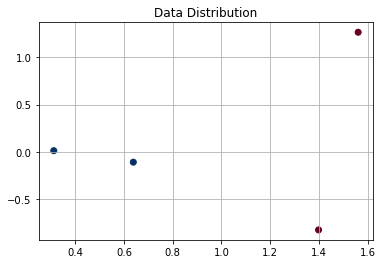

In [9]:
dl = ToyBlochSphereLoader(gap=np.pi/5)
np.random.seed(30)
X, y = dl(4, 0.1)
Plot_Data(X, y).plot()

In [10]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-kaist', group='internal', project='default')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('ibmq_manhattan') from IBMQ(hub='ibm-q-kaist', group='internal', project='default')>,
 <IBMQBackend('

In [11]:
from qiskit.test.mock import FakeMontreal as fake
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import QasmSimulator

In [12]:
var_form = RealAmplitudes(2, reps=3)
feature_map = TwoLocal(1, ['ry', 'rz'], skip_final_rotation_layer=True, reps=1)
optimizer = SPSA(maxiter=2**13, last_avg=2**10)
logger = get_loggers_add_handle(optimizer, VQAlgorithm)[0]

In [13]:
#quantum_instance = QuantumInstance(QasmSimulator.from_backend(provider.get_backend('ibmq_manhattan')), shots=2**13, seed_simulator=None, seed_transpiler=0, measurement_error_mitigation_cls=CompleteMeasFitter)
quantum_instance = QuantumInstance(QasmSimulator(), shots=2**18, seed_simulator=None, seed_transpiler=0)
qasvm = BlochSphereQASVM(var_form=var_form, optimizer=optimizer, training_data=X, training_label=y, quantum_instance=quantum_instance, C=100, k=0.1).dual
#qasvm.quantum_instance.compile_config['optimization_level']=3
#qasvm.quantum_instance.compile_config['layout_method'] = 'noise_adaptive'
#del qasvm.quantum_instance.qjob_config['wait']
#qc = qasvm.quantum_instance.transpile(qasvm.second_order_circuit)[0]
#print(qc.depth())
#qc.draw('mpl', idle_wires=False, fold=-1)

In [14]:
qasvm.quantum_instance.backend

QasmSimulator(
backend_name='qasm_simulator')

In [15]:
import dill
import pathlib
import uuid
qasvm.run()
dill.dump_session(logger.handlers[-1].baseFilename.split('.')[0]+'.dill')


# End Session

# Restart Session

In [16]:
import dill

import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)
import pathlib

p = pathlib.Path.home()/'QUIC-Projects'/'exp_logs'
#dill.load_session(max(p.glob('*.dill'), key=lambda p: p.stat().st_ctime))
files = sorted(p.glob('*.dill'), key=lambda p: p.stat().st_ctime, reverse=True)
log_files = sorted(p.glob('*.log'), key=lambda p: p.stat().st_ctime, reverse=True)
file_index = 0
dill.load_session(files[file_index])
exp_log = log_files[file_index]

In [17]:
print(qasvm)
print(qasvm.quantum_instance.run_config)

QASVM (qiskit)
	type: Dual
	backend: qasm_simulator
	error mitigation: None
	(C, k): (100, 0.1)
	accuracy: 1.0
RunConfig(max_credits=10, shots=262144)


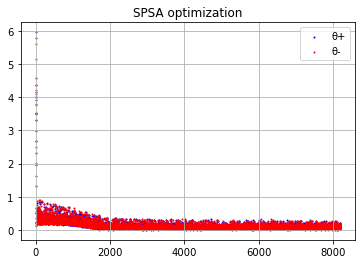

In [18]:
Plot_Log_From_SPSA(exp_log).plot(min_step=0, max_step=np.inf)

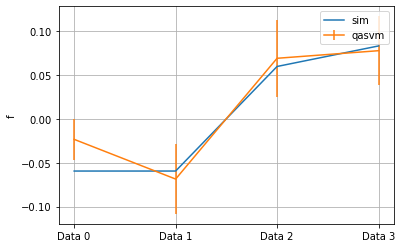

In [19]:
plt.plot(svm.f(X), label='sim')
res = np.array([qasvm.f(X) for _ in range(10)])
plt.errorbar(range(len(res.mean(axis=0))), res.mean(axis=0), yerr=2*res.std(axis=0), label='qasvm')
plt.xticks(range(4), [f'Data {i}' for i in range(4)])
plt.ylabel('f')
plt.legend()
plt.grid()

In [20]:
print(qasvm.optimizer.setting)

Optimizer: SPSA
-- gradient_support_level: 1
-- bounds_support_level: 1
-- initial_point_support_level: 3
-- options: {'save_steps': 1, 'last_avg': 1024}
-- max_evals_grouped: 1
-- maxiter: 8192
-- parameters: [0.16667982 0.1        0.602      0.101      0.        ]
-- skip_calibration: False



In [21]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.4',
 'qiskit-aer': '0.7.5',
 'qiskit-ignis': '0.5.2',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.2',
 'qiskit': '0.23.6'}

In [22]:

from classifiers.utils import clean_exp_logs
clean_exp_logs()

In [23]:
svm

BinarySVM: (REDUCED_QASVM)
	Kernel: SingleQubit
	HyperParameter: None
	Optimization Status: optimal
	Iterations: 5

In [24]:
print(qasvm.quantum_instance.backend.properties().last_update_date)

AttributeError: 'NoneType' object has no attribute 'last_update_date'